[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

## Zero-shot Object Detection using DeepSeek-VL2

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-deepseek-vl-2.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2412.10302-b31b1b.svg)](https://arxiv.org/abs/2412.10302)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/deepseek-ai/DeepSeek-VL2)

**[DeepSeek-VL2](https://github.com/deepseek-ai/DeepSeek-VL2)** is an advanced series of large Mixture-of-Experts (MoE) Vision-Language Models that demonstrates state-of-the-art capabilities for understanding and analyzing images, text, and documents. DeepSeek-VL2 models excel at visual question answering, optical character recognition, document/table/chart understanding, and visual grounding. Available in 3 sizes: [tiny (3B)](https://huggingface.co/deepseek-ai/deepseek-vl2-tiny), [small (16B)](https://huggingface.co/deepseek-ai/deepseek-vl2-small), and [base (27B)](https://huggingface.co/deepseek-ai/deepseek-vl2), DeepSeek-VL2 leverages DeepSeekMoE models with the Multi-head Latent Attention mechanism enabling efficient inference and high throughput.

## Environment setup

### Configure your API keys

To benchmark Qwen2.5-VL, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [76]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `A100 GPU`, and then click `Save`.

In [24]:
!nvidia-smi

Mon Jul 28 09:26:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             51W /  400W |   37361MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Install dependencies

Installs all required python libraries, including [`deepseek_vl2`](https://github.com/deepseek-ai/DeepSeek-VL2) and [`supervision`](https://github.com/roboflow/supervision) for visualization.

In [ ]:
# Install DeepSeek-2
!git clone https://github.com/deepseek-ai/DeepSeek-VL2
%cd DeepSeek-VL2
!pip install -qq -e .

# Install Supervision
!pip install -qq -U git+https://github.com/roboflow/supervision.git@develop

!pip install -qq "numpy<2"

### Download example data

In [28]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Load DeepSeek-VL2 Model

Loads the DeepSeek-VL2 Model (and its processor) from Hugging Face, preparing the model for inference.

In [ ]:
import torch
from transformers import AutoModelForCausalLM
from deepseek_vl2.models import DeepseekVLV2Processor, DeepseekVLV2ForCausalLM


MODEL_ID_OR_PATH = "deepseek-ai/deepseek-vl2-small"
vl_chat_processor = DeepseekVLV2Processor.from_pretrained(MODEL_ID_OR_PATH)
tokenizer = vl_chat_processor.tokenizer

vl_gpt = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True, torch_dtype=torch.bfloat16
)
vl_gpt = vl_gpt.cuda().eval()

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


processor_config.json: 0.00B [00:00, ?B/s]

Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:100002
Add image token = ['<image>'] to the tokenizer
<image>:100003
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:100004
<|/ref|>:100005
<|det|>:100006
<|/det|>:100007
<|grounding|>:100008
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:100009
<|Assistant|>:100010



config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000004.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model-00002-of-000004.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model-00003-of-000004.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model-00004-of-000004.safetensors:   0%|          | 0.00/6.52G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## DeepSeek-VL2 Inference and Visualization

### Define helper functions

Creates a function `run_deepseek_vl2_inference` to run text + image prompts using DeepSeek-VL2. The function uses **incremental pre-filling** to enable inference using DeepSeek-VL2-Tiny and DeepSeek-VL2-Small with 40GB GPU VRAM.

In [32]:
from typing import Optional
from deepseek_vl2.utils.io import load_pil_images


def run_deepseek_vl2_inference(
    image_path: str,
    user_prompt: str,
    system_prompt: Optional[str] = None,
) -> str:
    # create the conversation data structure for DeepSeek-VL2
    conversation = [
        {
            "role": "<|User|>",
            "content": user_prompt,
            "images": [image_path],
        },
        {
            "role": "<|Assistant|>",
            "content": ""
        },
    ]

    images = load_pil_images(conversation)
    system_prompt = "" if system_prompt is None else system_prompt

    # run the chat processor to get the pre-processed inputs
    prepared_inputs = vl_chat_processor(
        conversations=conversation,
        images=images,
        force_batchify=True,
        system_prompt=system_prompt,
    ).to(vl_gpt.device)

    with torch.inference_mode():
        # run image encoder to get the image embeddings
        inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepared_inputs)

        # incremental_prefilling when using 40G GPU for vl2-small
        inputs_embeds, past_key_values = vl_gpt.incremental_prefilling(
            input_ids=prepared_inputs.input_ids,
            images=prepared_inputs.images,
            images_seq_mask=prepared_inputs.images_seq_mask,
            images_spatial_crop=prepared_inputs.images_spatial_crop,
            attention_mask=prepared_inputs.attention_mask,
            chunk_size=512 # prefilling size
        )

        # run the model to get the response
        outputs = vl_gpt.generate(
            inputs_embeds=inputs_embeds,
            input_ids=prepared_inputs.input_ids,
            images=prepared_inputs.images,
            images_seq_mask=prepared_inputs.images_seq_mask,
            images_spatial_crop=prepared_inputs.images_spatial_crop,
            attention_mask=prepared_inputs.attention_mask,
            past_key_values=past_key_values,
            pad_token_id=tokenizer.eos_token_id,
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            max_new_tokens=512,
            do_sample=False,
            use_cache=True,
        )

        token_ids = outputs[0][len(prepared_inputs.input_ids[0]):]
        token_ids = token_ids.cpu().tolist()
        result = tokenizer.decode(token_ids, skip_special_tokens=False)
        return images[0], result

In [33]:
from PIL import Image
import supervision as sv


def annotate_image(image: Image.Image, detections: sv.Detections) -> Image.Image:
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(smart_position=True)
    annotated_image = box_annotator.annotate(
        scene=image, detections=detections
    )
    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=detections
    )
    return annotated_image

## Object localization using DeepSeek-VL2

### Detect "chair"s in the image

Prompts the model to detect all the chairs in the image, outputs the object localization coordinates, and parse and visualize the results.

In [49]:
IMAGE_PATH = "dog-3.jpeg"
PROMPT = "<image>\n<|ref|>chair<|/ref|>"

image, result = run_deepseek_vl2_inference(IMAGE_PATH, PROMPT)

print(result)

<|ref|>chair<|/ref|><|det|>[[116, 484, 638, 881], [558, 400, 829, 567], [673, 396, 764, 431], [853, 398, 997, 569]]<|/det|><｜end▁of▁sentence｜>


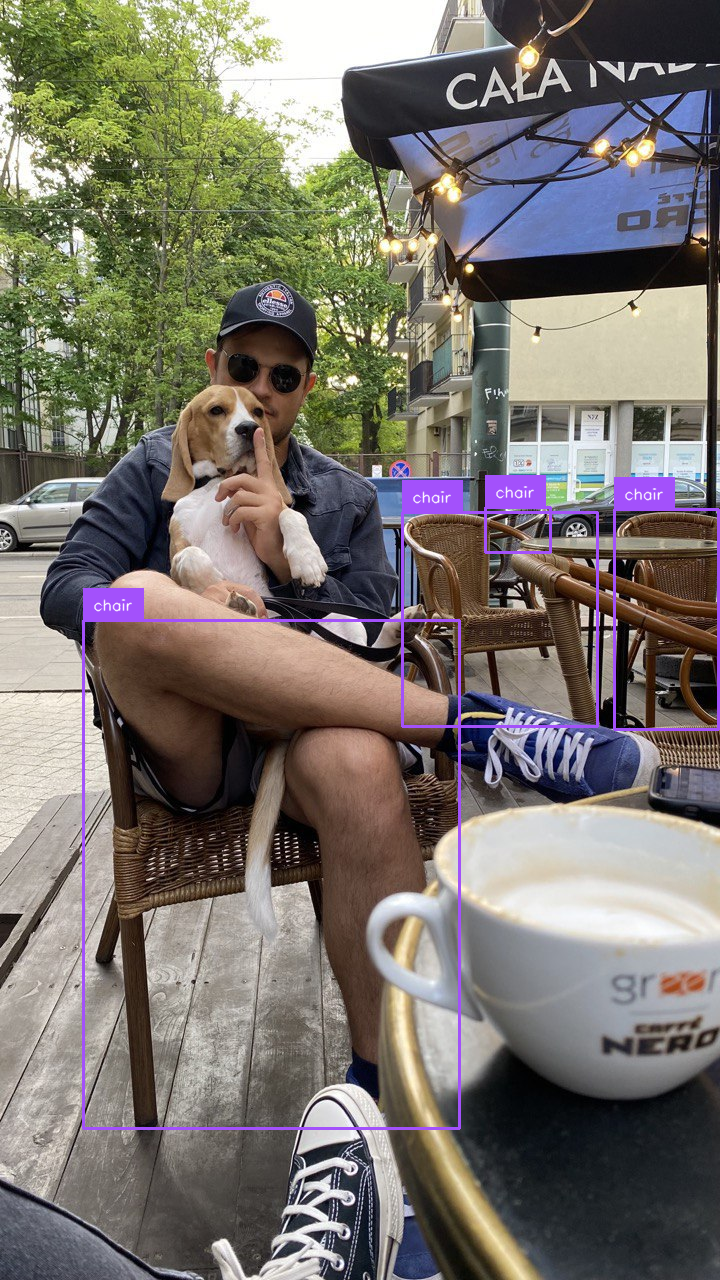

In [50]:
detections = sv.Detections.from_vlm(
    vlm=sv.VLM.DEEPSEEK_VL_2, result=result, resolution_wh=image.size
)

annotated_image = annotate_image(image, detections)

annotated_image

### Detect "the chair with the man sitting in it"

Filters the request to a more specific target object and visualizes the bounding box.

In [47]:
IMAGE_PATH = "dog-3.jpeg"
PROMPT = "<image>\n<|ref|>the chair with the man sitting in it<|/ref|>"

image, result = run_deepseek_vl2_inference(IMAGE_PATH, PROMPT)

print(result)

<|ref|>the chair with the man sitting in it<|/ref|><|det|>[[119, 485, 637, 883]]<|/det|><｜end▁of▁sentence｜>


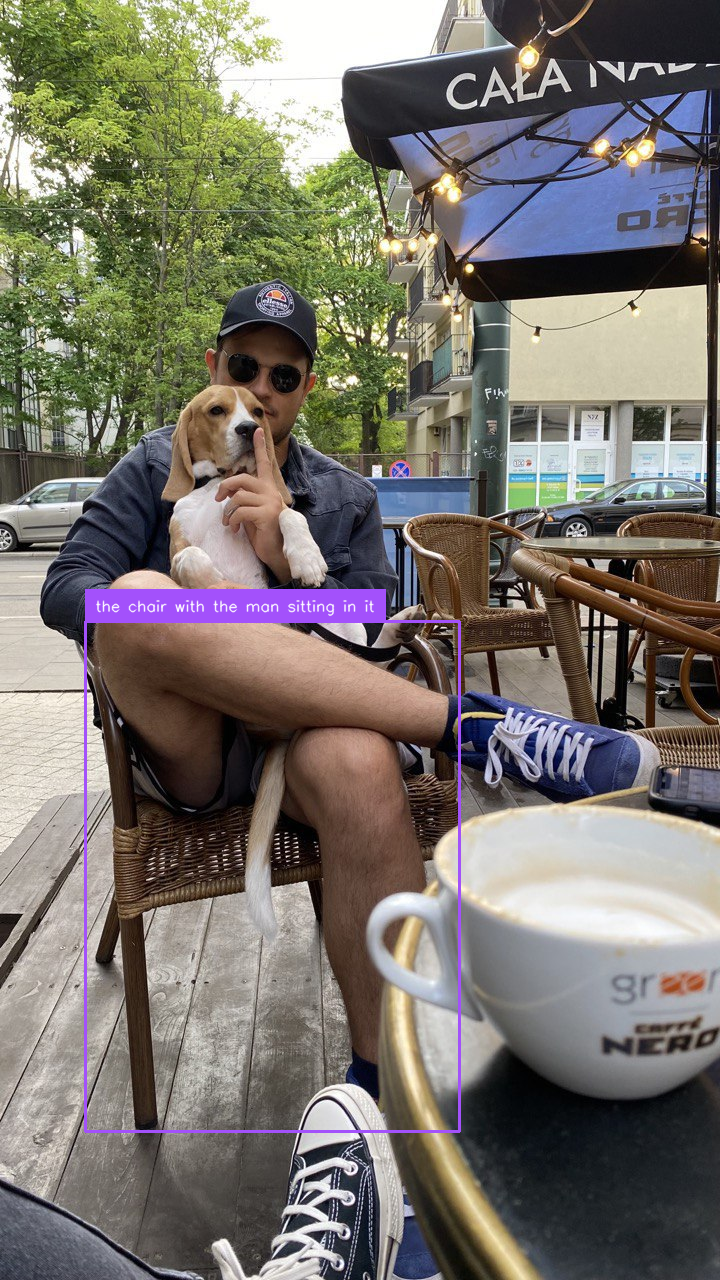

In [48]:
detections = sv.Detections.from_vlm(
    vlm=sv.VLM.DEEPSEEK_VL_2, result=result, resolution_wh=image.size
)

annotated_image = annotate_image(image, detections)

annotated_image

### Detect "rightmost glass"

Asks the model to outline the glass most right in the image, then annotates and displays it.

In [70]:
IMAGE_PATH = "dog-2.jpeg"
PROMPT = "<image>\n<|ref|>rightmost glass<|/ref|>"

image, result = run_deepseek_vl2_inference(IMAGE_PATH, PROMPT)

print(result)

<|ref|>rightmost glass<|/ref|><|det|>[[660, 694, 889, 882]]<|/det|><｜end▁of▁sentence｜>


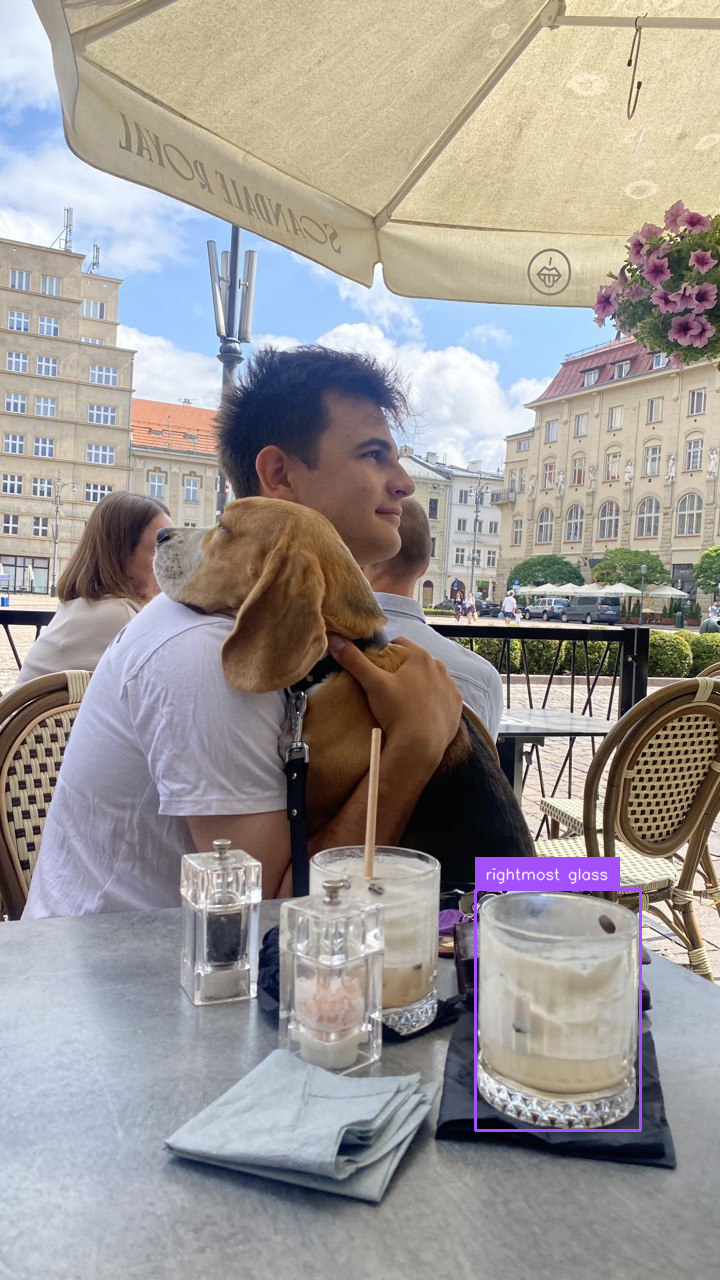

In [71]:
detections = sv.Detections.from_vlm(
    vlm=sv.VLM.DEEPSEEK_VL_2, result=result, resolution_wh=image.size
)

annotated_image = annotate_image(image, detections)

annotated_image

In [74]:
IMAGE_PATH = "dog-2.jpeg"
PROMPT = "<image>\n<|ref|>straw<|/ref|>"

image, result = run_deepseek_vl2_inference(IMAGE_PATH, PROMPT)

print(result)

<|ref|>straw<|/ref|><|det|>[[493, 567, 528, 696]]<|/det|><｜end▁of▁sentence｜>


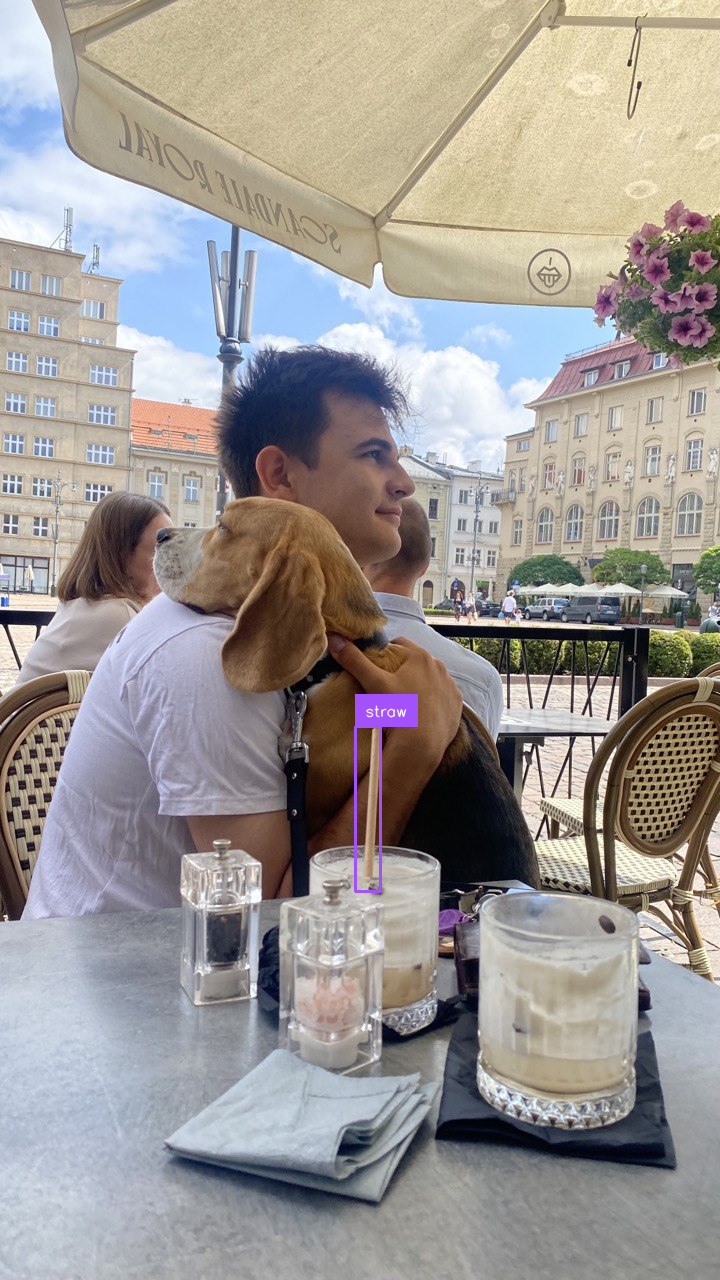

In [75]:
detections = sv.Detections.from_vlm(
    vlm=sv.VLM.DEEPSEEK_VL_2, result=result, resolution_wh=image.size
)

annotated_image = annotate_image(image, detections)

annotated_image

## DeepSeek-VL2 on Roboflow Dataset

### Download and load dataset

Installs the [`roboflow`](https://github.com/roboflow/roboflow-python) SDK, downloads a dataset, and load it as `DetectionDataset` using `supervision`.

In [77]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.6 MB/s eta 0:00:00


In [78]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/work-safe-project/safety-vest---v4/dataset/3", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Safety-vest---v4-3 in coco:: 100%|██████████| 438/438 [00:00<00:00, 4375.77it/s]


In [79]:
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

### Inference on Roboflow dataset

Runs DeepSeek-VL2 on a real-world dataset image (detecting helmets), then visualizes detections.

In [80]:
IMAGE_PATH = ds[0][0]
PROMPT = "<image>\n<|ref|>helmet<|/ref|>"

image, result = run_deepseek_vl2_inference(IMAGE_PATH, PROMPT)

print(result)

<|ref|>helmet<|/ref|><|det|>[[62, 317, 179, 425], [160, 270, 262, 372], [269, 299, 351, 381]]<|/det|><｜end▁of▁sentence｜>


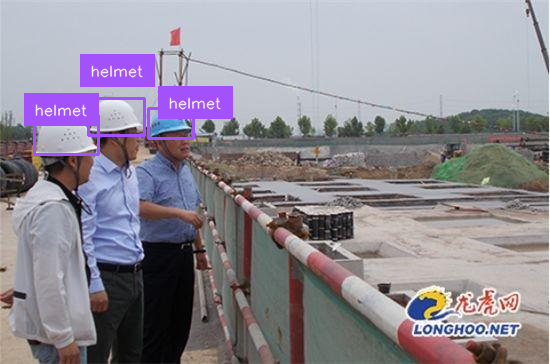

In [81]:
detections = sv.Detections.from_vlm(
    vlm=sv.VLM.DEEPSEEK_VL_2, result=result, resolution_wh=image.size
)

annotated_image = annotate_image(image, detections)

annotated_image

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>